# Calculate the number of cycles to fatigue failure {#ref_cycles_to_failure}

This example shows how to generate and use a result file to calculate
the cycles to failure result for a simple model.

Material data is manually imported, Structural Steel from Ansys
Mechanical:

-   Youngs Modulus (youngsSteel)
-   Poisson\'s Ratio (prxySteel)
-   SN curve (sn_data)

The first step is to generate a simple model with high stress and save
the results .rst file locally to myDir (default is \"C:\\temp\"). For
this, we provide a short pyMAPDL script.

The cycles to failure result is the (interpolated) negative of the
stress result. The higher the stress result, the lower the number of
cycles to failure.


In [1]:
from ansys.dpf import core as dpf
from ansys.dpf.core import examples
import numpy as np

The first step is to generate a simple model with high stress


In [2]:
# # Material parameters from Ansys Mechanical Structural Steel
youngsSteel = 200e9
prxySteel = 0.3
sn_data = np.empty((11, 2))  # initialize empty np matrix
sn_data[:, 0] = [10, 20, 50, 100, 200, 2000, 10000, 20000, 1e5, 2e5, 1e6]
sn_data[:, 1] = [
    3.999e9,
    2.8327e9,
    1.896e9,
    1.413e9,
    1.069e9,
    4.41e8,
    2.62e8,
    2.14e8,
    1.38e8,
    1.14e8,
    8.62e7,
]

The .rst file used is already available, but can be obtained using the
short pyMAPDL code below:


In [3]:
# # ### Launch pymapdl to generate rst file in myDir
# from ansys.mapdl.core import launch_mapdl
# import os
#
#
# mapdl = launch_mapdl()
# mapdl.prep7()
# # Model
# mapdl.cylind(0.5, 0, 10, 0)
# mapdl.mp("EX", 1, youngsSteel)
# mapdl.mp("PRXY", 1, prxySteel)
# mapdl.mshape(key=1, dimension='3d')
# mapdl.et(1, "SOLID186")
# mapdl.esize(0.3)
# mapdl.vmesh('ALL')
#
# # #### Boundary Conditions: fixed constraint
# mapdl.nsel(type_='S', item='LOC', comp='Z', vmin=0)
# mapdl.d("all", "all")
# mapdl.nsel(type_='S', item='LOC', comp='Z', vmin=10)
# nnodes = mapdl.get("NumNodes", "NODE", 0, "COUNT")
# mapdl.f(node="ALL", lab="fy", value=-13e6 / nnodes)
# mapdl.allsel()
#
# # #### Solve
# mapdl.run("/SOLU")
# sol_output = mapdl.solve()
# rst = os.path.join(mapdl.directory, 'file.rst')
# mapdl.exit()
# print('apdl model solved.')

PyDPF-Core is then used to post-process the .rst file to estimate the
cycles to failure.


In [4]:
# Comment the following line if solving the MAPDL problem first.
rst = examples.download_cycles_to_failure()

# Import the result as a DPF Model object.
model = dpf.Model(rst)
print(model)

DPF Model
------------------------------
Static analysis
Unit system: SI: m, kg, s, V, A, K
Physics Type: Mechanical
Available results:
     -  displacement: Nodal Displacement
     -  reaction_force: Nodal Force   
     -  element_nodal_forces: ElementalNodal Element nodal Forces
     -  stress: ElementalNodal Stress 
     -  elemental_volume: Elemental Volume
     -  stiffness_matrix_energy: Elemental Energy-stiffness matrix
     -  artificial_hourglass_energy: Elemental Hourglass Energy
     -  thermal_dissipation_energy: Elemental thermal dissipation energy
     -  kinetic_energy: Elemental Kinetic Energy
     -  co_energy: Elemental co-energy
     -  incremental_energy: Elemental incremental energy
     -  elastic_strain: ElementalNodal Strain
     -  thermal_strain: ElementalNodal Thermal Strains
     -  thermal_strains_eqv: ElementalNodal Thermal Strains eqv
     -  swelling_strains: ElementalNodal Swelling Strains
     -  structural_temperature: ElementalNodal Temperature
-----

Get the von mises equivalent stress, requires an operator.


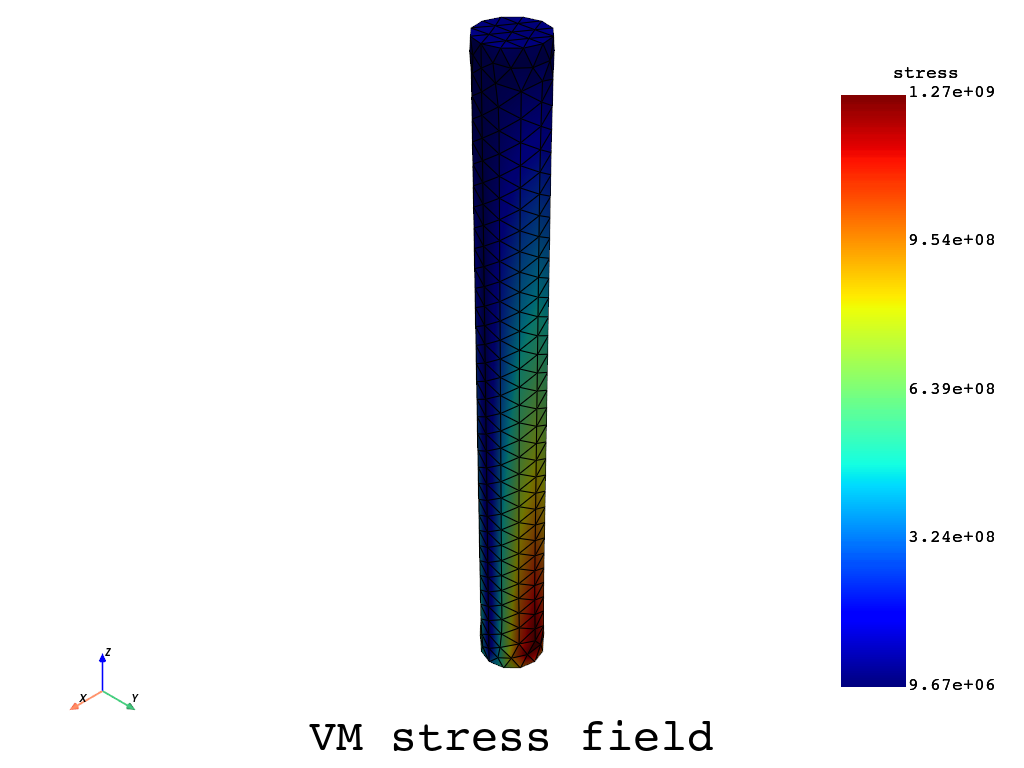

In [5]:
s_eqv_op = dpf.operators.result.stress_von_mises(data_sources=model)
vm_stress_fc = s_eqv_op.eval()
vm_stress_field = vm_stress_fc[0]
vm_stress_field.plot(text="VM stress field")

Use NumPy to interpolate the results.


In [6]:
# Inverse the sn_data
x_values = sn_data[:, 1][::-1]  # the x values are the stress ranges in ascending order
y_values = sn_data[:, 0][::-1]  # y values are inverted cycles to failure

# Interpolate cycles to failure for the VM values
cycles_to_failure = np.interp(vm_stress_field.data, x_values, y_values)

Generate a cycles_to_failure DPF Field


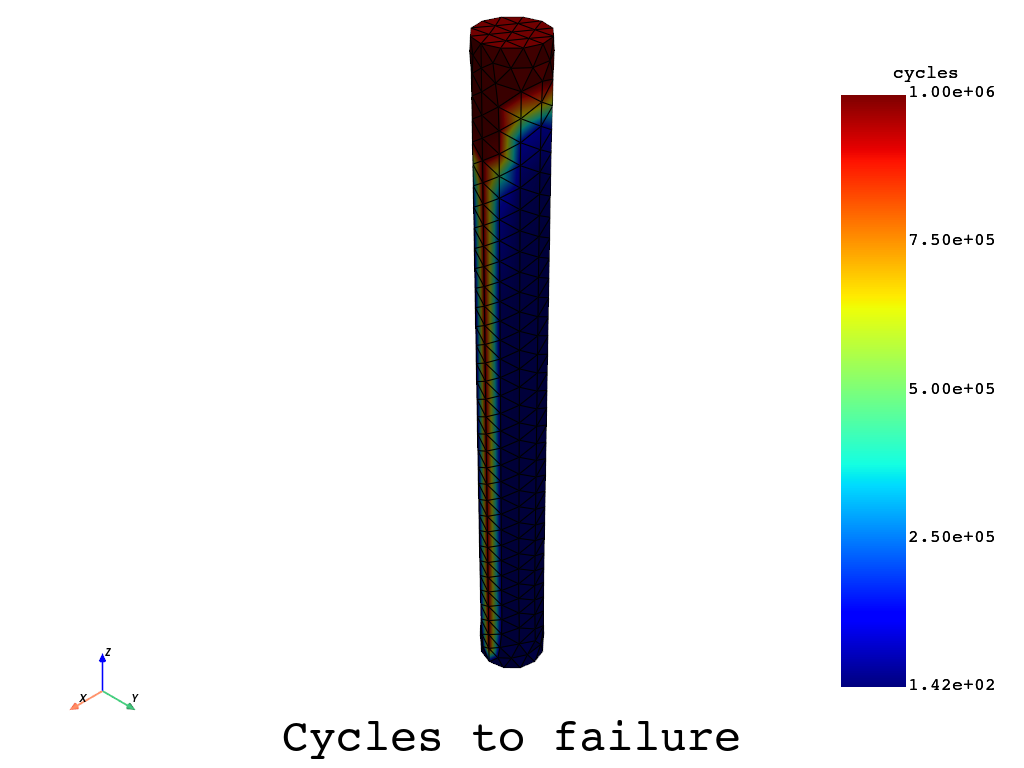

In [7]:
# Create an empty field
cycles_to_failure_field = dpf.Field(
    nentities=len(vm_stress_field.scoping),
    nature=dpf.natures.scalar,
    location=dpf.locations.nodal,
)
# Populate the field
cycles_to_failure_field.scoping = vm_stress_field.scoping
cycles_to_failure_field.meshed_region = vm_stress_field.meshed_region
cycles_to_failure_field.data = cycles_to_failure

# Plot the field
sargs = dict(title="cycles", fmt="%.2e")
cycles_to_failure_field.plot(text="Cycles to failure", scalar_bar_args=sargs)